# Platform Engagement and Growth Analytics

## Data Setup

In [11]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8")
sns.set_palette("muted")

con=duckdb.connect()

con.execute("""
CREATE TABLE users_raw AS SELECT * FROM read_csv_auto('data/users.csv');
CREATE TABLE sessions_raw AS SELECT * FROM read_csv_auto('data/sessions.csv');
CREATE TABLE title_raw AS SELECT * FROM read_csv_auto('data/titles.csv');
""")

In [12]:
print("\nSample data from each table:")
print("================================")
print("Users Table:")
print(f"\n{con.execute("SELECT * FROM users_raw LIMIT 5").fetchdf()}")
print("================================")
print("Sessions Table:")
print(f"\n{con.execute("SELECT * FROM sessions_raw LIMIT 5").fetchdf()}")
print("Sessions Table:")
print(f"\n{con.execute("SELECT * FROM title_raw LIMIT 5").fetchdf()}")


Sample data from each table:
Users Table:

  user_id signup_date cancel_date region plan_type
0  U00001  2020-06-20         NaT     ES   Premium
1  U00002  2020-05-27  2020-11-19     UK     Basic
2  U00003  2021-02-21         NaT     ES  Standard
3  U00004  2020-07-02         NaT     KR   Premium
4  U00005  2023-08-14         NaT     UK     Basic
Sessions Table:

  session_id user_id       date device  duration title_id
0    S000001  U00661 2025-01-19     pc       8.0    T0061
1    S000002  U00192 2022-02-12  phone      22.0    T0117
2    S000003  U00911 2025-09-24     tv      52.0    T0145
3    S000004  U00747 2024-07-08  phone      17.0    T0025
4    S000005  U00651 2022-02-06  phone      81.0    T0048
Sessions Table:

  title_id country_of_origin  runtime        genre content_type
0    T0001                US       45    Animation      TV Show
1    T0002                BR      154  Documentary        Movie
2    T0003                JP       50      Romance      TV Show
3    T0004  

## Data Cleaning

### User Table

#### Checking for issues

In [13]:
print(con.execute("SELECT * FROM users_raw").fetchdf().info())
print(con.execute("SELECT * FROM users_raw LIMIT 5").fetchdf())


print("region values:")
print(con.execute("SELECT region, COUNT(region) FROM users_raw GROUP BY region").fetchdf())

print("plan_type values:")
print(con.execute("SELECT plan_type, COUNT(plan_type) FROM users_raw GROUP BY plan_type").fetchdf())

print("Date Values")
print(con.execute("""
SELECT 
    signup_date,
    cancel_date,
FROM users_raw;
""").fetchdf().describe())

print("\nNull Values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(region IS NULL) AS null_region,
       COUNTIF(plan_type IS NULL) AS null_plan_type,
       COUNTIF(user_id IS NULL) AS null_user_id,
       COUNTIF(signup_date IS NULL) AS null_signup_date,
       COUNTIF(cancel_date IS NULL) AS null_cancel_date
FROM users_raw;
""").fetchdf())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013 entries, 0 to 1012
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      1013 non-null   object        
 1   signup_date  1013 non-null   datetime64[us]
 2   cancel_date  572 non-null    datetime64[us]
 3   region       990 non-null    object        
 4   plan_type    999 non-null    object        
dtypes: datetime64[us](2), object(3)
memory usage: 39.7+ KB
None
  user_id signup_date cancel_date region plan_type
0  U00001  2020-06-20         NaT     ES   Premium
1  U00002  2020-05-27  2020-11-19     UK     Basic
2  U00003  2021-02-21         NaT     ES  Standard
3  U00004  2020-07-02         NaT     KR   Premium
4  U00005  2023-08-14         NaT     UK     Basic
region values:
   region  count(region)
0      ES             77
1      FR             79
2      JP             75
3      BR             65
4      IT             57
5      MX      

#### Clean and validate, export to pandas dataframe

In [14]:
con.execute("""
CREATE OR REPLACE TABLE users_clean AS
WITH ranked AS (
  SELECT
    *,
    ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY signup_date DESC, cancel_date NULLS LAST) AS rn
  FROM users_raw
)
SELECT
  user_id,
  CAST(signup_date AS DATE) AS signup_date,
  CASE 
    WHEN TRY_CAST(cancel_date AS DATE) IS NULL THEN NULL
    WHEN TRY_CAST(cancel_date AS DATE) < TRY_CAST(signup_date AS DATE) THEN NULL  -- fix bad ordering
    ELSE CAST(cancel_date AS DATE)
  END AS cancel_date,
  region,
  plan_type
FROM ranked
WHERE rn = 1
  AND user_id IS NOT NULL
;
""")

print("region values:")
print(con.execute("SELECT region, COUNT(region) FROM users_clean GROUP BY region").fetchdf())

print("plan_type values:")
print(con.execute("SELECT plan_type, COUNT(plan_type) FROM users_clean GROUP BY plan_type").fetchdf())

print("\nNull Values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(region IS NULL) AS null_region,
       COUNTIF(plan_type IS NULL) AS null_plan_type,
       COUNTIF(user_id IS NULL) AS null_user_id,
       COUNTIF(signup_date IS NULL) AS null_signup_date,
       COUNTIF(cancel_date IS NULL) AS null_cancel_date
FROM users_clean;
""").fetchdf())

users = con.execute("""SELECT * FROM users_clean""").fetch_df()

region values:
   region  count(region)
0      ES             76
1      FR             78
2      JP             74
3      BR             65
4      IT             57
5      IN             63
6      US             64
7      NL             52
8      SE             58
9      UK             71
10     DE             61
11     KR             69
12     CA             60
13     MX             77
14   None              0
15     AU             52
plan_type values:
  plan_type  count(plan_type)
0      None                 0
1   Premium               194
2     Basic               440
3  Standard               352

Null Values:
   total_rows  null_region  null_plan_type  null_user_id  null_signup_date  \
0        1000         23.0            14.0           0.0               0.0   

   null_cancel_date  
0             434.0  


#### Looking for outliers

  user_id signup_date cancel_date region plan_type
0  U00001  2020-06-20         NaT     ES   Premium
1  U00002  2020-05-27  2020-11-19     UK     Basic
2  U00012  2021-11-01  2023-09-01     FR     Basic
3  U00013  2024-08-12  2024-08-20     FR  Standard
4  U00024  2020-05-17         NaT     IN     Basic


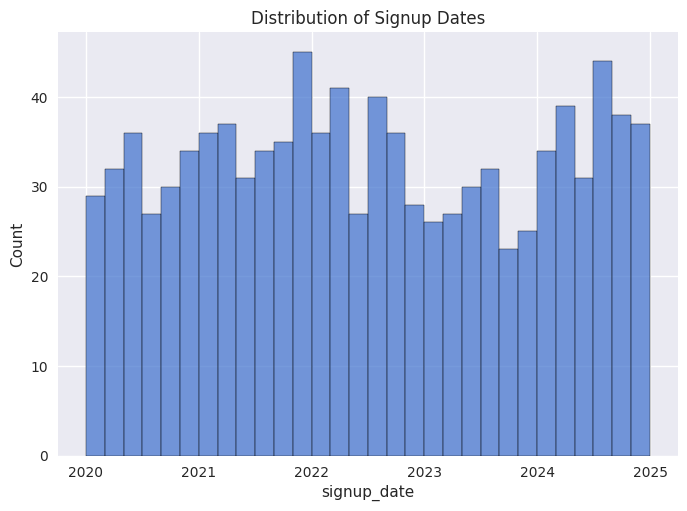

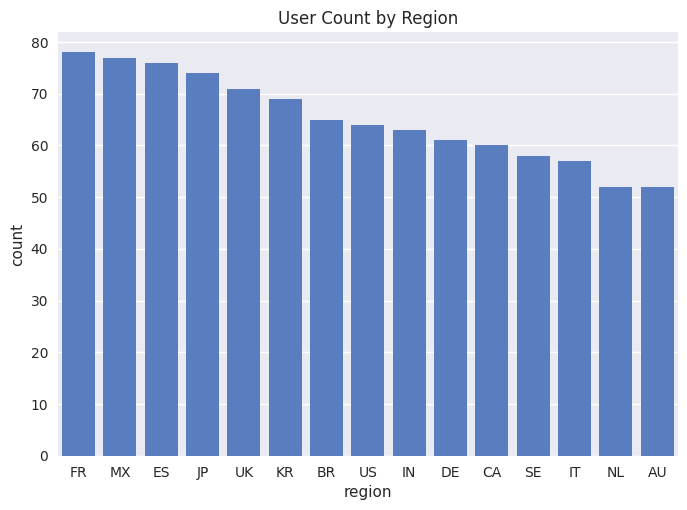

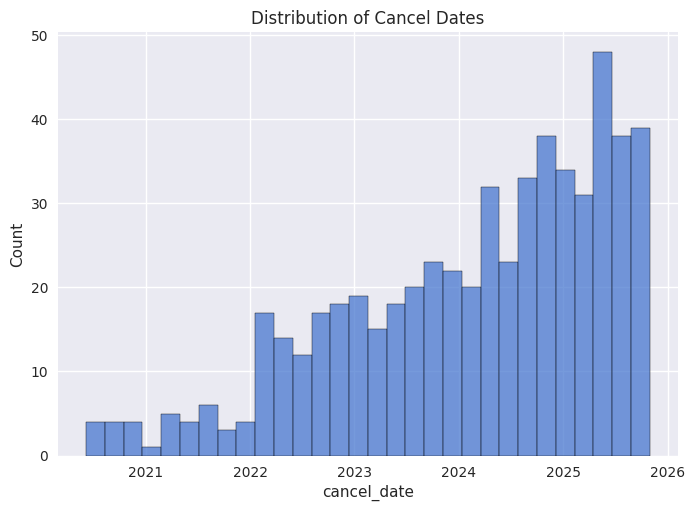

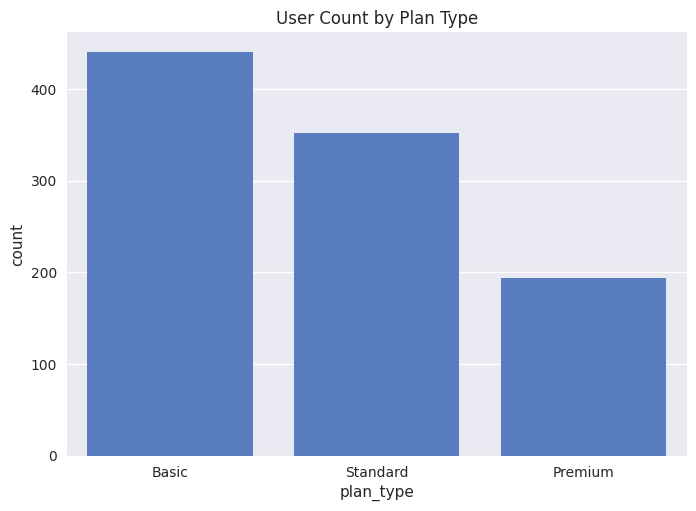

In [15]:
print(users.head())

sns.histplot(users, x='signup_date', bins=30)
plt.title('Distribution of Signup Dates')
plt.show()

sns.countplot(data=users, x='region', order=users['region'].value_counts().index)
plt.title('User Count by Region')
plt.show()

sns.histplot(users, x='cancel_date', bins=30)
plt.title('Distribution of Cancel Dates')
plt.show()

sns.countplot(data=users, x='plan_type', order=users['plan_type'].value_counts().index)
plt.title('User Count by Plan Type')
plt.show()

### Sessions Table

#### Description

In [16]:
print(con.execute("SELECT * FROM sessions_raw").fetchdf().info())

print("\nSample values:")
print(con.execute("SELECT * FROM sessions_raw LIMIT 5").fetchdf())

print("\nSession Quantitative Data Statistics:")
print(con.execute("SELECT date, duration FROM sessions_raw").fetchdf().describe())

print("\nSession ID Distinct Count:")
print(con.execute("""
SELECT COUNT(DISTINCT session_id) AS distinct_session_ids,
       COUNT(session_id) AS total_session_ids
FROM sessions_raw;
""").fetchdf())

print("\nDevice values:")
print(con.execute("SELECT device, COUNT(device) from sessions_raw GROUP BY device").fetchdf())

print("\nNull Values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(duration IS NULL) AS null_duration,
       COUNTIF(device IS NULL) AS null_device,
       COUNTIF(user_id IS NULL) AS null_user_id,
       COUNTIF(date IS NULL) AS null_date
FROM sessions_raw;
""").fetchdf())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   session_id  10000 non-null  object        
 1   user_id     10000 non-null  object        
 2   date        10000 non-null  datetime64[us]
 3   device      9752 non-null   object        
 4   duration    9980 non-null   float64       
 5   title_id    9970 non-null   object        
dtypes: datetime64[us](1), float64(1), object(4)
memory usage: 468.9+ KB
None

Sample values:
  session_id user_id       date device  duration title_id
0    S000001  U00661 2025-01-19     pc       8.0    T0061
1    S000002  U00192 2022-02-12  phone      22.0    T0117
2    S000003  U00911 2025-09-24     tv      52.0    T0145
3    S000004  U00747 2024-07-08  phone      17.0    T0025
4    S000005  U00651 2022-02-06  phone      81.0    T0048

Session Quantitative Data Statistics:
                            

#### Standardize Columns & Handle Nulls

In [17]:
con.execute("""
CREATE OR REPLACE TABLE sessions_clean AS
  SELECT
    session_id,
    CAST(date AS DATE) AS date,
    CASE 
      WHEN TRY_CAST(duration AS DOUBLE) IS NULL OR TRY_CAST(duration AS DOUBLE) < 0 THEN NULL
      ELSE TRY_CAST(duration AS DOUBLE)
    END AS duration,
    device,
    user_id,
    title_id
  FROM sessions_raw
  WHERE session_id IS NOT NULL AND duration < 300 AND duration > 0 AND user_id IS NOT NULL AND title_id IS NOT NULL AND date IS NOT NULL
""")

print(con.execute("SELECT * FROM sessions_clean").fetchdf().info())

print("\nSample values:")
print(con.execute("SELECT * FROM sessions_clean LIMIT 5").fetchdf())

print("\nSession Quantitative Data Statistics:")
print(con.execute("SELECT date, duration FROM sessions_clean").fetchdf().describe())

print("\nSession ID Distinct Count:")
print(con.execute("""
SELECT COUNT(DISTINCT session_id) AS distinct_session_ids,
       COUNT(session_id) AS total_session_ids
FROM sessions_clean;
""").fetchdf())

print("\nDevice values:")
print(con.execute("SELECT device, COUNT(device) from sessions_clean GROUP BY device").fetchdf())

print("\nNull Values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(duration IS NULL) AS null_duration,
       COUNTIF(device IS NULL) AS null_device,
       COUNTIF(user_id IS NULL) AS null_user_id,
       COUNTIF(date IS NULL) AS null_date,
      COUNTIF(title_id IS NULL) AS null_title_id
FROM sessions_clean;
""").fetchdf())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9938 entries, 0 to 9937
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   session_id  9938 non-null   object        
 1   date        9938 non-null   datetime64[us]
 2   duration    9938 non-null   float64       
 3   device      9692 non-null   object        
 4   user_id     9938 non-null   object        
 5   title_id    9938 non-null   object        
dtypes: datetime64[us](1), float64(1), object(4)
memory usage: 466.0+ KB
None

Sample values:
  session_id       date  duration device user_id title_id
0    S000001 2025-01-19       8.0     pc  U00661    T0061
1    S000002 2022-02-12      22.0  phone  U00192    T0117
2    S000003 2025-09-24      52.0     tv  U00911    T0145
3    S000004 2024-07-08      17.0  phone  U00747    T0025
4    S000005 2022-02-06      81.0  phone  U00651    T0048

Session Quantitative Data Statistics:
                             

#### Dedup

In [18]:
print("\nRemaining Duplicate Rows:")
print(con.execute("""
WITH duplicate_sessions AS (
SELECT session_id
FROM sessions_clean
GROUP BY session_id
HAVING COUNT(*) > 1
)
SELECT
                  date,
                  duration,
                  device,
                  title_id
FROM sessions_clean
WHERE session_id IN (SELECT session_id FROM duplicate_sessions)
ORDER BY session_id, user_id, date, duration, device, title_id NULLS LAST
""").fetchdf())

con.execute("""
CREATE OR REPLACE TABLE sessions_clean AS
WITH ranked AS (
SELECT
    *,
    ROW_NUMBER() OVER (PARTITION BY session_id ORDER BY user_id, date, duration, device, title_id NULLS LAST) AS rn
FROM sessions_clean
)
SELECT
    session_id,
    date,
    duration,
    device,
    user_id,
    title_id
FROM ranked
WHERE rn = 1 AND duration IS NOT NULL
""")

print("\nSession ID Distinct Count:")
print(con.execute("""
SELECT COUNT(DISTINCT session_id) AS distinct_session_ids,
       COUNT(session_id) AS total_session_ids
FROM sessions_clean;
""").fetchdf())

print("\nRemaining Duplicate Rows:")
print(con.execute("""
WITH duplicate_sessions AS (
SELECT session_id
FROM sessions_clean
GROUP BY session_id
HAVING COUNT(*) > 1
)
SELECT
                  date,
                  duration,
                  device,
                  title_id
FROM sessions_clean
WHERE session_id IN (SELECT session_id FROM duplicate_sessions)
ORDER BY session_id, user_id, date, duration, device, title_id NULLS LAST
""").fetchdf())

print("\nNull Values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(duration IS NULL) AS null_duration,
       COUNTIF(device IS NULL) AS null_device,
       COUNTIF(user_id IS NULL) AS null_user_id,
       COUNTIF(date IS NULL) AS null_date,
       COUNTIF(title_id IS NULL) AS null_title_id
FROM sessions_clean;
""").fetchdf())
print("\nSession Quantitative Data Statistics:")
print(con.execute("SELECT date, duration FROM sessions_clean").fetchdf().describe())
print("\nSample values:")
print(con.execute("SELECT * FROM sessions_clean").fetch_df().head())


Remaining Duplicate Rows:
          date  duration device title_id
0   2025-02-14      17.0  phone    T0031
1   2025-02-14      17.0  phone    T0031
2   2020-09-16      15.0  phone    T0128
3   2020-09-16      15.0  phone    T0128
4   2021-04-06       1.0     tv    T0030
..         ...       ...    ...      ...
193 2025-03-06      56.0     pc    T0097
194 2023-03-20      12.0     tv    T0195
195 2023-03-20      12.0     tv    T0195
196 2025-07-03       6.0  phone    T0083
197 2025-07-03       6.0  phone    T0083

[198 rows x 4 columns]

Session ID Distinct Count:
   distinct_session_ids  total_session_ids
0                  9839               9839

Remaining Duplicate Rows:
Empty DataFrame
Columns: [date, duration, device, title_id]
Index: []

Null Values:
   total_rows  null_duration  null_device  null_user_id  null_date  \
0        9839            0.0        243.0           0.0        0.0   

   null_title_id  
0            0.0  

Session Quantitative Data Statistics:
              

Export to Dataframe

In [19]:
sessions = con.execute("""SELECT * FROM sessions_clean""").fetch_df()
sessions.head()

,session_id,date,duration,device,user_id,title_id
0,S000001,2025-01-19,8.0,pc,U00661,T0061
1,S000049,2023-12-14,2.0,tv,U00297,T0011
2,S000066,2023-03-07,1.0,None,U00182,T0162
3,S000068,2022-01-31,19.0,phone,U00457,T0025
4,S000141,2023-09-15,1.0,phone,U00401,T0158


#### Finding Outliers

  session_id       date  duration device user_id title_id
0    S000001 2025-01-19       8.0     pc  U00661    T0061
1    S000049 2023-12-14       2.0     tv  U00297    T0011
2    S000066 2023-03-07       1.0   None  U00182    T0162
3    S000068 2022-01-31      19.0  phone  U00457    T0025
4    S000141 2023-09-15       1.0  phone  U00401    T0158


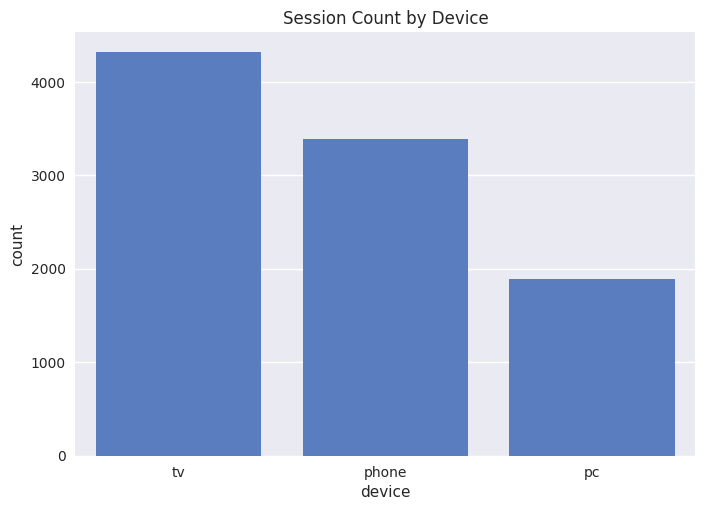

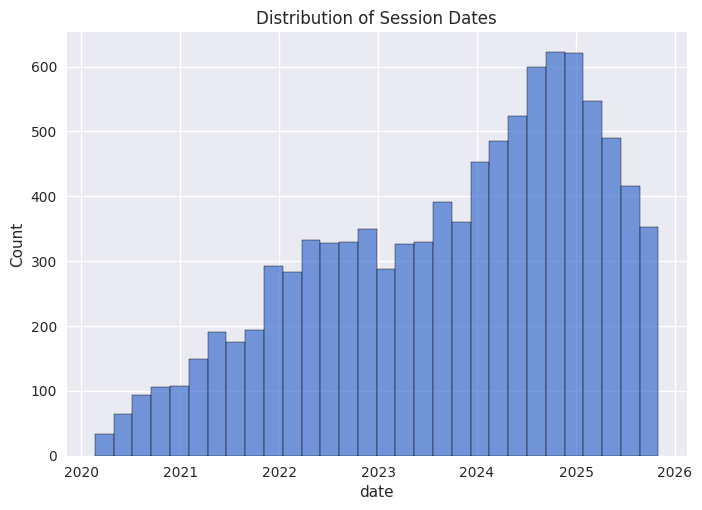

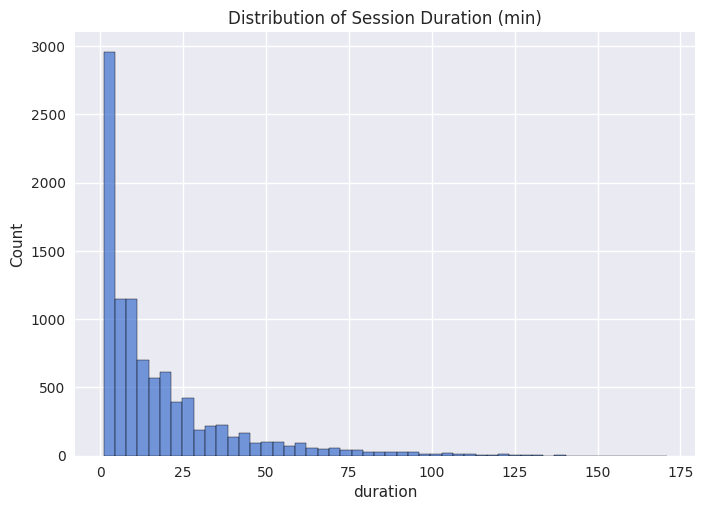

In [20]:
print(sessions.head())

sns.countplot(data=sessions, x='device', order=sessions['device'].value_counts().index)
plt.title('Session Count by Device')
plt.show()

sns.histplot(sessions, x='date', bins=30)
plt.title('Distribution of Session Dates')
plt.show()

sns.histplot(sessions, x='duration', bins=50)
plt.title('Distribution of Session Duration (min)')
plt.show()

### Content Table

#### Description


Sample values:
  title_id country_of_origin  runtime        genre content_type
0    T0001                US       45    Animation      TV Show
1    T0002                BR      154  Documentary        Movie
2    T0003                JP       50      Romance      TV Show
3    T0004                NL       25    Animation      TV Show
4    T0005                ES      120       Comedy        Movie

title Raw Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title_id           207 non-null    object
 1   country_of_origin  207 non-null    object
 2   runtime            207 non-null    int64 
 3   genre              204 non-null    object
 4   content_type       207 non-null    object
dtypes: int64(1), object(4)
memory usage: 8.2+ KB
None

Genre values:
          genre  count(genre)
0       Romance            22
1     Animatio

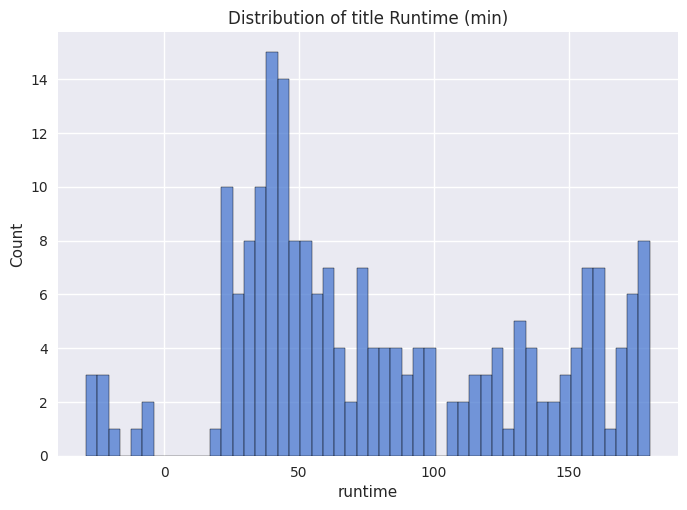

In [29]:
print("\nSample values:")
print(con.execute(""" SELECT * FROM title_raw LIMIT 5; """).fetch_df())

print("\ntitle Raw Table Info:")
print(con.execute("""SELECT * FROM title_raw""").fetch_df().info())

print ("\nGenre values:")
print(con.execute("SELECT genre, COUNT(genre) from title_raw GROUP BY genre").fetchdf())

print("\nDescriptive Statistics for Quantitative Columns:")
print(con.execute("SELECT runtime FROM title_raw").fetchdf().describe())

print("\nDuplicate Count:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNT(DISTINCT title_id) AS distinct_title_ids
FROM title_raw;
""").fetchdf())

sns.histplot(con.execute("SELECT runtime FROM title_raw").fetch_df(), x='runtime', bins=50)
plt.title('Distribution of title Runtime (min)')
plt.show()

#### Standardize Columns & Dedup

In [ ]:
con.execute("""
CREATE OR REPLACE TABLE content_clean AS
  WITH ranked AS (
  SELECT
      *,
      ROW_NUMBER() OVER (PARTITION BY content_id ORDER BY genre, runtime, release_date NULLS LAST) AS rn
  FROM content_raw
  )
  SELECT
    content_id,
    genre,
    CASE
      WHEN TRY_CAST(runtime AS DOUBLE) IS NULL OR TRY_CAST(runtime AS DOUBLE) < 0 THEN NULL
      ELSE TRY_CAST(runtime AS DOUBLE)
    END AS runtime,
    CASE
      WHEN TRY_CAST(release_date AS DATE) IS NULL THEN NULL
      ELSE TRY_CAST(release_date AS DATE)
    END AS release_date,
    production_cost_usd,
    licensed_flag
  FROM ranked
  WHERE rn = 1 AND content_id IS NOT NULL AND runtime < 500 AND runtime > 0
""")

#### Visualize & Export to Dataframe

In [ ]:
print("\nSample values:")
print(con.execute(""" SELECT * FROM content_clean LIMIT 5; """).fetch_df())

print("\nContent Raw Table Info:")
print(con.execute("""SELECT * FROM content_clean""").fetch_df().info())

print ("\nGenre values:")
print(con.execute("SELECT genre, COUNT(genre) from content_clean GROUP BY genre").fetchdf())

print("\nDescriptive Statistics for Quantitative Columns:")
print(con.execute("SELECT runtime_min, release_date FROM content_clean").fetchdf().describe())

print("\nDuplicate Count:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNT(DISTINCT content_id) AS distinct_content_ids
FROM content_clean;
""").fetchdf())

sns.histplot(con.execute("SELECT runtime_min FROM content_clean").fetch_df(), x='runtime_min', bins=50)
plt.title('Distribution of Content Runtime (min)')
plt.show()

sns.histplot(con.execute("SELECT production_cost_usd FROM content_clean").fetch_df(), x='production_cost_usd', bins=50)
plt.title('Distribution of Content Production Cost (USD)')
plt.show()

sns.histplot(con.execute("SELECT release_date FROM content_clean").fetch_df(), x='release_date', bins=50)
plt.title('Distribution of Content Release Dates')
plt.show()

sns.countplot(data=con.execute("SELECT * FROM content_clean").fetch_df(), x='genre', order=con.execute("SELECT genre, COUNT(genre) from content_clean GROUP BY genre").fetch_df()['genre'])
plt.title('Content Count by Genre')
plt.show()

content = con.execute("""SELECT * FROM content_clean""").fetch_df()

Handle missing watch_completion_pct in sessions

In [ ]:
# 1) Keep a 1-row-per-content lookup of runtimes
runtime_lookup = (
    content[['content_id', 'runtime_min']]
    .drop_duplicates('content_id')
    .set_index('content_id')
)

# 2) Attach runtime to sessions (left join on content_id)
sessions = sessions.join(runtime_lookup, on='content_id', how='left')

# 3) Build a mask of rows that need filling
needs_fill = sessions['watch_completion_pct'].isna()

# 4) Avoid divide-by-zero or missing runtime
valid_runtime = sessions['runtime_min'] > 0

# 5) Compute completion % = (watched / total) * 100, clamp to [0, 100]
calc_pct = (
    (sessions['duration_min'] / sessions['runtime_min']) * 100
).clip(lower=0, upper=100)

# 6) Only fill where missing AND runtime is valid AND duration is not null
fill_mask = needs_fill & valid_runtime & sessions['duration_min'].notna()

sessions.loc[fill_mask, 'watch_completion_pct'] = calc_pct.loc[fill_mask]

# (Optional) If you don’t want to keep the joined column:
sessions = sessions.drop(columns=['runtime_min'])
# sessions = sessions.dropna(subset=['watch_completion_pct'])

sessions.info()

## EDA

### Stakeholder Questions:
1. What are the overall trends in engagement/activity during this time period? How do they vary by different segments?
2. Are we keeping the users we acquire, and what segments have the best/worst retention?
3. How has our user base been growing?
4. What content is performing best/worst?


### Metrics

| KPI                                       | Formula / Logic                               | Why it matters                    |
| ----------------------------------------- | --------------------------------------------- | --------------------------------- |
| **Daily/Monthly Active Users**            | Count distinct users per day/month            | Tracks engagement & activity      |
| **Engagement Rate**                       | Sessions per active user per day              | How “sticky” product is           |
| **Average Watch Time / Session Duration** | Avg(duration_min)                             | Content/Session quality           |
| **Content Completion Rate**               | Avg(watch_completion_pct)                     | Indicates quality & engagement    |
| **Retention Rate**                        | (Returning users at t+30 / users active at t) | User loyalty                      |
| **Churn Rate**                            | 1 – retention                                 | Attrition analysis                |
| **Subscriber Growth Rate**                | (New subs – churned subs) / prior subs        | Measures platform growth          |

In [ ]:
# Merge Data
df = sessions.merge(
    users,
    on='user_id',
    how='left',
    suffixes=('_session', '_user')
).merge(
    content,
    on='content_id',
    how='left',
    suffixes=('', '_content')
)
df = df.rename(columns={'duration_min': 'watch_duration_min', 'runtime_min' : 'content_runtime_min', 'price_ucsd' : 'plan_price_usd', 'device': 'session_device', 'content_type': 'session_content_type'})

df.head()

df['days_before_signup'] = (df['signup_date'] - df['date']).dt.days
invalid = df[df['days_before_signup'] > 0]

invalid['days_before_signup'].describe()

In [ ]:
invalid_sessions = df[df['date'] < df['signup_date']]

print(f"Invalid sessions: {len(invalid_sessions):,} ({len(invalid_sessions) / len(df):.2%} of total)")

### 1) What are the overall trends in engagement/activity during this time period? How do they vary by different segments?

#### User Activity

In [ ]:
print(df.head())

# MAU

monthly_active_users = (
    df.groupby(pd.Grouper(key='date', freq='M'))['user_id']
    .nunique()
    .reset_index(name='monthly_active_users')
)
sns.lineplot(data=monthly_active_users, x='date', y='monthly_active_users')
plt.title('Monthly Active Users Over Time')
plt.show()

# Sessions Per User

MoM_sessions_per_user = (
    df.groupby(pd.Grouper(key='date', freq='M'))['user_id']
    .value_counts()
    .reset_index(name='sessions_count')
)

MoM_avg_sessions_per_user = (
    MoM_sessions_per_user.groupby('date')['sessions_count']
    .mean()
    .reset_index(name='avg_sessions_per_user')
)

# MoM Average Watch time per User per day
MoM_avg_watch_time_per_user_per_day = (
    df.groupby([pd.Grouper(key='date', freq='M'), 'user_id'])['watch_duration_min']
    .sum()
    .reset_index()
    .groupby('date')['watch_duration_min']
    .mean()
    .reset_index(name='avg_watch_time_per_user_per_day_min')
)
sns.lineplot(data=MoM_avg_watch_time_per_user_per_day, x='date', y='avg_watch_time_per_user_per_day_min')
plt.title('MoM Daily Watch Time per User')
plt.show()

# Content Completion Rate Over Time
MoM_avg_watch_completion_per_session = (
    df.groupby(pd.Grouper(key='date', freq='M'))['watch_completion_pct']
    .mean()
    .reset_index(name='avg_watch_completion_per_session_pct')
)
sns.lineplot(data=MoM_avg_watch_completion_per_session, x='date', y='avg_watch_completion_per_session_pct')
plt.title('MoM Average Watch Completion % per Session')
plt.show()

# MoM avg watch time per session
MoM_avg_watch_time_per_session = (
    df.groupby(pd.Grouper(key='date', freq='M'))['watch_duration_min']
    .mean()
    .reset_index(name='avg_watch_time_per_session_min')
)
sns.lineplot(data=MoM_avg_watch_time_per_session, x='date', y='avg_watch_time_per_session_min')
plt.title('MoM Average Watch Time per Session')
plt.show()

### Subscriber growth, retention, and churn

In [ ]:
# New Subscribers Per Month
new_subscribers_per_month = (
    users.groupby(pd.Grouper(key='signup_date', freq='M'))['user_id']
    .nunique()
    .reset_index(name='new_subscribers')
)
sns.lineplot(data=new_subscribers_per_month, x='signup_date', y='new_subscribers')
plt.title('New Subscribers Per Month')
plt.show()

# Cancellations Per Month
cancellations_per_month = (
    users.groupby(pd.Grouper(key='cancel_date', freq='M'))['user_id']
    .nunique()
    .reset_index(name='cancellations')
)
sns.lineplot(data=cancellations_per_month, x='cancel_date', y='cancellations')
plt.title('Cancellations Per Month')
plt.show()

#### Segmentation

In [ ]:
# Segmentation By Region and Plan Type
monthly_active_users_by_region = (
    df.groupby([pd.Grouper(key='date', freq='M'), 'region'])['user_id']
    .nunique()
    .reset_index(name='monthly_active_users')
)
monthly_active_users_by_region = monthly_active_users_by_region[monthly_active_users_by_region['region'] != 'Unknown']

sns.lineplot(data=monthly_active_users_by_region, x='date', y='monthly_active_users', hue='region')
plt.title('Monthly Active Users by Region Over Time')
plt.show()

monthly_active_users_by_plan = (
    df.groupby([pd.Grouper(key='date', freq='M'), 'plan_type'])['user_id']
    .nunique()
    .reset_index(name='monthly_active_users')
)

monthly_active_users_by_plan = monthly_active_users_by_plan[monthly_active_users_by_plan['plan_type'] != 'Unknown']

sns.lineplot(data=monthly_active_users_by_plan, x='date', y='monthly_active_users', hue='plan_type')
plt.title('Monthly Active Users by Plan Type Over Time')
plt.show()